# Residential Heat Pump Case Study 5:  
Created: 10/2022  
Erik Janssen, Analyst Sustainable Technologies Evaluation Program (STEP)  
Toronto and Region Conservation Authority (TRCA)  

## 1 Introduction
This Jupyter Notebook was used to analyze the changes in utility consumption pre- and post-retrofit for the air-source heat pump (ASHP) system analyzed in the accompanying case study. The basic process of the analysis is:

1) Import utility data pre- and post-retrofit.  

2) Create a linear regression model of the pre-retrofit data as a function of heating degree days (HDDs) - and CDDs if necessary. 

3) Determine savings by comparing baseline against actual post-retrofit utility data. 

4) Ensure that the utility impacts attributed to the ASHP system are reasonable by calculating the average COP from the gas savings and electricity increase. Compare the calculated average COP against manufacturer data (i.e. an expected COP). The COP calculated from the utility data should be near that expected based on the manufacturer data. Note COP was not explicitly monitoried, this is just to ensure that it is reasonable to attribute a certain gas savings to the ASHP based on how much electricity it consumed.

5) Estimate utility rates and calculate other parameters like cost and carbon savings. 

6) Consider utility implications for carbon pricing schedule looking out to 2030 and beyond.

7) Perform a full net present value (NPV) business case analysis.

## 2 Libraries

In [134]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.dates as mdates
from matplotlib.patches import Patch

# Set some basic parameters for plotting and visualizing data
font = {'size'   : 16}
plt.rc('font', **font)
step_blue = "#00a3af"
step_gold = "#f8a81d"
pd.set_option('display.max_columns', None)
MonthFmt = mdates.DateFormatter('%m/%Y')

## 3 Import Data

### 3.1 Import Weather Data

In [135]:
# Import hourly weather data file for Toronto and calculate HDDs and CDDs
# Assumed building balance points to create the best linear relationships 
toronto_weather = pd.read_csv("weatherstats_toronto_hourly_10yr.csv",parse_dates=True, infer_datetime_format=True)
toronto_weather.date_time_local = [datetime.datetime.strptime(x,'%m/%d/%Y %H:%M') for x in toronto_weather.date_time_local]
toronto_weather = toronto_weather[['date_time_local','temperature']]
toronto_weather['HDDs'] = [(16 - x)*(1/24) if (x < 16) else 0 for x in toronto_weather.temperature] 
toronto_weather['CDDs'] = [(x-25)*(1/24) if (x > 25) else 0 for x in toronto_weather.temperature] 
toronto_weather.index = toronto_weather.date_time_local
del toronto_weather['date_time_local']
toronto_weather.head()

,temperature,HDDs,CDDs
date_time_local,,,
2022-07-25 11:00:00,20.4,0.0,0.0
2022-07-25 10:00:00,20.1,0.0,0.0
2022-07-25 09:00:00,19.8,0.0,0.0
2022-07-25 08:00:00,19.1,0.0,0.0
2022-07-25 07:00:00,18.4,0.0,0.0


In [136]:
# Function that determines total HDDs in a given window of time
def HDD_total(start_date,end_date):
    temp_df = toronto_weather.loc[(toronto_weather.index>=start_date)&(toronto_weather.index<(end_date + datetime.timedelta(days=1)))]
    total_HDDs = temp_df.HDDs.sum()
    total_CDDs = temp_df.CDDs.sum()
    return {'HDDs':total_HDDs,
            'CDDs':total_CDDs}

### 3.2 Import Gas Data

In [137]:
# Import data
# Note "Yes" for Actual dates indicates that the "To" and "From" were confirmed via
# the downloaded data from the Enbridge portal. Prior to June 2020, the "To" and "From"
# dates are estimated since the data was recorded by the homeowner did have the exact
# time windows. This is fine. While the data prior to June 2020 was included in some
# visualizations, it was not used in the energy savings analysis itself.
gas_data = pd.read_csv('Gas_Consumption.csv',parse_dates = ['To','From'])
gas_data.tail(24)

,Month,Year,m3,From,To,Actual Dates
18,Jul,2020,34,2020-06-23,2020-07-23,Yes
19,Aug,2020,34,2020-07-24,2020-08-21,Yes
20,Sep,2020,36,2020-08-22,2020-09-23,Yes
21,Oct,2020,153,2020-09-24,2020-10-22,Yes
22,Nov,2020,190,2020-10-23,2020-11-23,Yes
23,Dec,2020,353,2020-11-24,2020-12-21,Yes
24,Jan,2021,357,2020-12-22,2021-01-22,Yes
25,Feb,2021,517,2021-01-23,2021-02-20,Yes
26,Mar,2021,307,2021-02-21,2021-03-23,Yes
27,Apr,2021,231,2021-03-24,2021-04-20,Yes


Text(0, 0.5, 'Gas Consumption [m$^{3}$]')

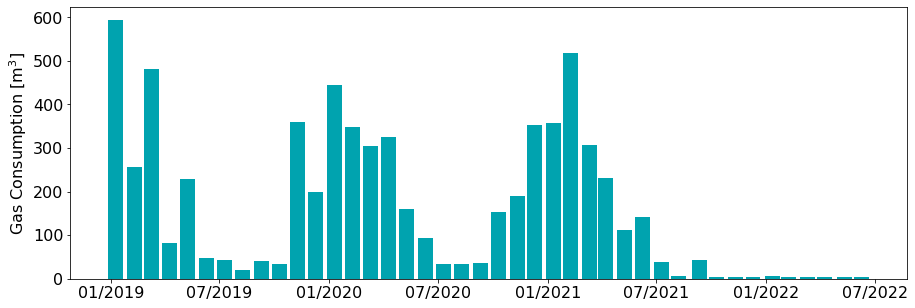

In [138]:
# Quick Visualization
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(gas_data.To,gas_data.m3, width = -25, align = 'edge',color = step_blue)
ax.xaxis.set_major_formatter(MonthFmt)
ax.set_ylabel('Gas Consumption [m$^{3}$]')

It's clear the gas load has almost entirely been eliminated post-retrofit.

Now add HDDs and CDDs to the gas dataframe.

In [139]:
# Add HDDs to gas dataframe
gas_data['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(gas_data.From,gas_data.To)]
gas_data['CDDs'] = [HDD_total(x,y)['CDDs'] for x,y in zip(gas_data.From,gas_data.To)]
gas_data.tail(24)

,Month,Year,m3,From,To,Actual Dates,HDDs,CDDs
18,Jul,2020,34,2020-06-23,2020-07-23,Yes,0.562500,44.241667
19,Aug,2020,34,2020-07-24,2020-08-21,Yes,1.841667,24.570833
20,Sep,2020,36,2020-08-22,2020-09-23,Yes,39.533333,9.241667
21,Oct,2020,153,2020-09-24,2020-10-22,Yes,116.908333,0.295833
22,Nov,2020,190,2020-10-23,2020-11-23,Yes,292.900000,0.000000
23,Dec,2020,353,2020-11-24,2020-12-21,Yes,422.483333,0.000000
24,Jan,2021,357,2020-12-22,2021-01-22,Yes,529.212500,0.000000
25,Feb,2021,517,2021-01-23,2021-02-20,Yes,666.270833,0.000000
26,Mar,2021,307,2021-02-21,2021-03-23,Yes,455.425000,0.000000
27,Apr,2021,231,2021-03-24,2021-04-20,Yes,221.558333,0.000000


Define pre- and post-retrofit dataframes for the gas data. Note the install took place in early October 2021. 

In [140]:
pre_gas_data_2 = gas_data.loc[(gas_data.index > 9)&(gas_data.index < 18)].copy() # Winter 2019/2020
pre_gas_data = gas_data.loc[(gas_data.index > 21)&(gas_data.index < 30)].copy() # Winter 2020/2021
post_gas_data = gas_data.loc[(gas_data.index > 33)].copy() # Winter 2021/2022

In [141]:
# Have a look
pre_gas_data

,Month,Year,m3,From,To,Actual Dates,HDDs,CDDs
22,Nov,2020,190,2020-10-23,2020-11-23,Yes,292.900000,0.000000
23,Dec,2020,353,2020-11-24,2020-12-21,Yes,422.483333,0.000000
24,Jan,2021,357,2020-12-22,2021-01-22,Yes,529.212500,0.000000
25,Feb,2021,517,2021-01-23,2021-02-20,Yes,666.270833,0.000000
26,Mar,2021,307,2021-02-21,2021-03-23,Yes,455.425000,0.000000
27,Apr,2021,231,2021-03-24,2021-04-20,Yes,221.558333,0.000000
28,May,2021,111,2021-04-21,2021-05-21,Yes,187.012500,3.529167
29,Jun,2021,142,2021-05-22,2021-06-21,Yes,30.591667,13.991667


In [142]:
# Have a look
pre_gas_data_2

,Month,Year,m3,From,To,Actual Dates,HDDs,CDDs
10,Nov,2019,360,2019-10-23,2019-11-22,No,397.612500,0.000000
11,Dec,2019,200,2019-11-23,2019-12-22,No,502.745833,0.000000
12,Jan,2020,445,2019-12-23,2020-01-22,No,509.095833,0.000000
13,Feb,2020,349,2020-01-23,2020-02-22,No,570.358333,0.000000
14,Mar,2020,304,2020-02-23,2020-03-22,No,419.762500,0.000000
15,Apr,2020,326,2020-03-23,2020-04-22,No,339.087500,0.000000
16,May,2020,160,2020-04-23,2020-05-22,No,213.475000,0.000000
17,Jun,2020,94,2020-05-23,2020-06-22,No,22.933333,15.908333


In [143]:
# Have a look
post_gas_data

,Month,Year,m3,From,To,Actual Dates,HDDs,CDDs
34,Nov,2021,5,2021-10-23,2021-11-23,Yes,312.579167,0.000000
35,Dec,2021,5,2021-11-24,2021-12-22,Yes,419.112500,0.000000
36,Jan,2022,6,2021-12-23,2022-01-24,Yes,685.462500,0.000000
37,Feb,2022,5,2022-01-25,2022-02-19,Yes,566.616667,0.000000
38,Mar,2022,4,2022-02-20,2022-03-23,Yes,522.066667,0.000000
39,Apr,2022,5,2022-03-23,2022-04-21,Yes,343.312500,0.000000
40,May,2022,5,2022-04-22,2022-05-24,Yes,146.616667,1.437500
41,Jun,2022,5,2022-05-25,2022-06-22,Yes,18.170833,14.979167


Visualize gas consumption vs. HDDs.

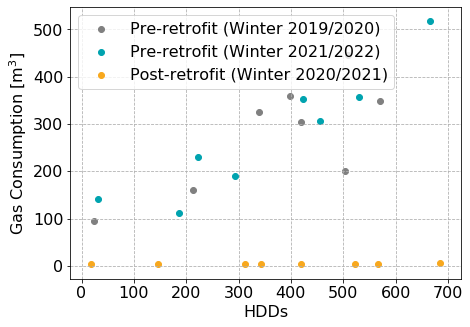

In [144]:
plt.figure(figsize=(7,5))
plt.scatter(pre_gas_data_2.HDDs,pre_gas_data_2.m3, color = 'grey', label = 'Pre-retrofit (Winter 2019/2020)')
plt.scatter(pre_gas_data.HDDs,pre_gas_data.m3, color = step_blue, label = 'Pre-retrofit (Winter 2021/2022)')
plt.scatter(post_gas_data.HDDs,post_gas_data.m3, color = step_gold, label = 'Post-retrofit (Winter 2020/2021)')

plt.ylabel('Gas Consumption [m$^{3}$]')
plt.xlabel('HDDs')
plt.grid(ls='--')
plt.legend()

As expected, pre-retrofit data is very linear. This will make it easy to model a baseline.

### 3.3 Import Electricity Data

In [145]:
elec_data = pd.read_csv('Elec_data.csv',parse_dates = ['To','From'])
elec_data.head(24)

,From,To,Off-Peak,Mid-Peak,On-Peak,kWh
0,2020-01-01,2020-01-31,192.65,57.35,59.80,309.80
1,2020-02-01,2020-02-29,17.01,46.20,40.48,103.69
2,2020-03-01,2020-03-31,69.91,34.71,29.70,134.32
3,2020-04-01,2020-04-30,261.68,0.00,0.00,261.68
4,2020-05-01,2020-05-31,279.40,0.00,0.00,279.40
5,2020-06-01,2020-06-30,395.71,0.00,0.00,395.71
6,2020-07-01,2020-07-31,35.31,0.00,0.00,35.31
7,2020-08-01,2020-08-31,275.81,102.20,142.99,521.00
8,2020-09-01,2020-09-30,153.93,49.52,50.55,254.00
9,2020-10-01,2020-10-31,148.12,44.68,52.52,245.32


In [146]:
# Add HDDs and CDDs
elec_data['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(elec_data.From,elec_data.To)]
elec_data['CDDs'] = [HDD_total(x,y)['CDDs'] for x,y in zip(elec_data.From,elec_data.To)]
elec_data

,From,To,Off-Peak,Mid-Peak,On-Peak,kWh,HDDs,CDDs
0,2020-01-01,2020-01-31,192.65,57.35,59.80,309.80,533.895833,0.000000
1,2020-02-01,2020-02-29,17.01,46.20,40.48,103.69,541.679167,0.000000
2,2020-03-01,2020-03-31,69.91,34.71,29.70,134.32,397.525000,0.000000
3,2020-04-01,2020-04-30,261.68,0.00,0.00,261.68,301.595833,0.000000
4,2020-05-01,2020-05-31,279.40,0.00,0.00,279.40,159.300000,3.687500
5,2020-06-01,2020-06-30,395.71,0.00,0.00,395.71,16.395833,18.295833
6,2020-07-01,2020-07-31,35.31,0.00,0.00,35.31,0.016667,50.200000
7,2020-08-01,2020-08-31,275.81,102.20,142.99,521.00,2.341667,20.204167
8,2020-09-01,2020-09-30,153.93,49.52,50.55,254.00,43.883333,1.870833
9,2020-10-01,2020-10-31,148.12,44.68,52.52,245.32,206.804167,0.000000


Text(0, 0.5, 'Electricity Consumption [kWh]')

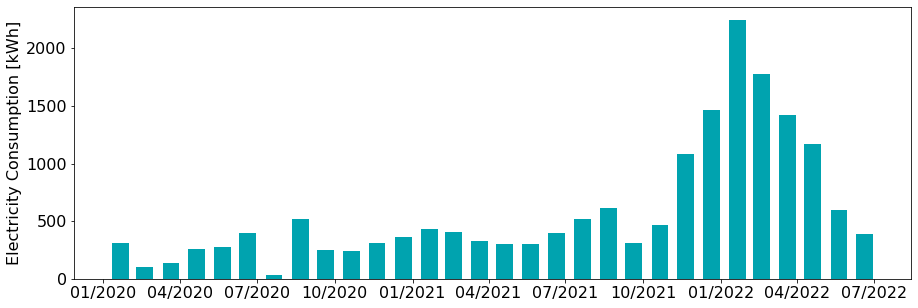

In [147]:
# Quick time-series visualization
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(elec_data.To,elec_data.kWh, width = -20, align = 'edge',color = step_blue)
ax.xaxis.set_major_formatter(MonthFmt)
ax.set_ylabel('Electricity Consumption [kWh]')

As expected, electricity consumption increased substantially post-retrofit.

In [148]:
pre_elec_data = elec_data.loc[(elec_data.index < 22)].copy()
pre_elec_data

,From,To,Off-Peak,Mid-Peak,On-Peak,kWh,HDDs,CDDs
0,2020-01-01,2020-01-31,192.65,57.35,59.80,309.80,533.895833,0.000000
1,2020-02-01,2020-02-29,17.01,46.20,40.48,103.69,541.679167,0.000000
2,2020-03-01,2020-03-31,69.91,34.71,29.70,134.32,397.525000,0.000000
3,2020-04-01,2020-04-30,261.68,0.00,0.00,261.68,301.595833,0.000000
4,2020-05-01,2020-05-31,279.40,0.00,0.00,279.40,159.300000,3.687500
5,2020-06-01,2020-06-30,395.71,0.00,0.00,395.71,16.395833,18.295833
6,2020-07-01,2020-07-31,35.31,0.00,0.00,35.31,0.016667,50.200000
7,2020-08-01,2020-08-31,275.81,102.20,142.99,521.00,2.341667,20.204167
8,2020-09-01,2020-09-30,153.93,49.52,50.55,254.00,43.883333,1.870833
9,2020-10-01,2020-10-31,148.12,44.68,52.52,245.32,206.804167,0.000000


In [149]:
post_elec_data = elec_data.loc[(elec_data.index > 21)].copy()
post_elec_data

,From,To,Off-Peak,Mid-Peak,On-Peak,kWh,HDDs,CDDs
22,2021-11-01,2021-11-30,713.25,176.45,191.15,1080.85,355.212500,0.000000
23,2021-12-01,2021-12-31,964.37,253.53,246.47,1464.37,447.708333,0.000000
24,2022-01-01,2022-01-31,1610.28,314.37,321.33,2245.98,732.379167,0.000000
25,2022-02-01,2022-02-28,1235.67,258.33,278.88,1772.88,562.070833,0.000000
26,2022-03-01,2022-03-31,963.42,217.97,242.93,1424.32,463.058333,0.000000
27,2022-04-01,2022-04-30,838.31,153.10,180.11,1171.52,284.004167,0.000000
28,2022-05-01,2022-05-31,426.49,83.14,88.50,598.13,74.758333,6.520833
29,2022-06-01,2022-06-30,260.76,64.17,65.12,390.05,16.991667,14.150000


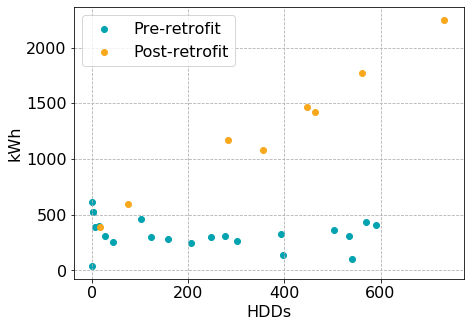

In [150]:
# Visualize vs. HDDs
plt.figure(figsize=(7,5))
plt.scatter(pre_elec_data.HDDs,pre_elec_data.kWh, color = step_blue, label = 'Pre-retrofit')
plt.scatter(post_elec_data.HDDs,post_elec_data.kWh, color = step_gold, label = 'Post-retrofit')
plt.ylabel('kWh')
plt.xlabel('HDDs')
plt.grid(ls='--')
plt.legend()

Cooling data was not included in the analysis. The electricity consumption post-retrofit shows a very clear relationship with the HDDs - as expected.

## 4 Define Linear Regression Models of Baseline Utility Consumption and Calculate Total Utility Consumption

We need linear regression baseline models so that we can determine a fair baseline as a point of comparison for the actual post-retrofit utility consumption. To do this, you model the gas and electricity consumption according to HDDs and then apply those models to the HDDs occuring during the post-retrofit period. This tells you what the utility consumption would have been with the old systems - normalizing for difference in weather year-to-year.

### 4.1 Baseline Models

coefficient of determination: 0.005206956871262491
intercept: 315.88473809646064
slope: [-0.03373755]


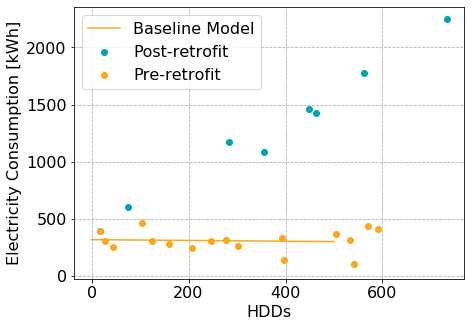

In [151]:
# Calculate regression line for baseline electricity data
x = np.array(pre_elec_data.loc[pre_elec_data.HDDs > 10].HDDs).reshape((-1, 1))
y = np.array(pre_elec_data.loc[pre_elec_data.HDDs > 10].kWh)
base_model_elec = LinearRegression()
base_model_elec.fit(x, y)
base_model_elec_r_sq = base_model_elec.score(x, y)
print('coefficient of determination:', base_model_elec_r_sq)
print('intercept:', base_model_elec.intercept_)
print('slope:', base_model_elec.coef_)

# Define baseline elec function
def base_elec_model(HDDs):
    kWh = base_model_elec.coef_[0]*HDDs + base_model_elec.intercept_
    return kWh

# Visualize
plt.figure(figsize = (7,5))
plt.grid(ls='--')
x = [0,500]
y = [base_elec_model(a) for a in x]
plt.scatter(post_elec_data.loc[post_elec_data.HDDs > 10].HDDs,post_elec_data.loc[post_elec_data.HDDs > 10].kWh, color = step_blue, label = 'Post-retrofit')
plt.scatter(pre_elec_data.loc[pre_elec_data.HDDs > 10].HDDs,pre_elec_data.loc[pre_elec_data.HDDs > 10].kWh, color = step_gold, label = 'Pre-retrofit')
plt.plot(x,y, color = step_gold, label = 'Baseline Model')
plt.xlabel('HDDs')
plt.ylabel('Electricity Consumption [kWh]')
plt.legend()

The baseline electricity model is effectively a constant value across all HDDs.

Now do gas.

coefficient of determination (R2): 0.8650300540600103
intercept: 63.394734599506506
slope: [0.60626267]


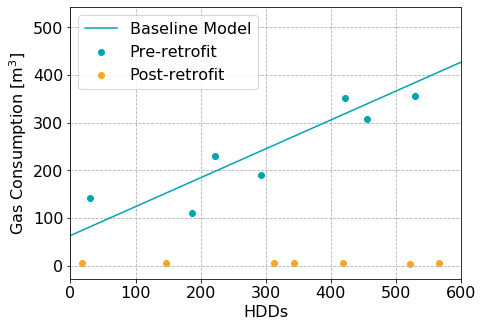

In [152]:
# Calculate regression line for baseline data
x = np.array(pre_gas_data.HDDs).reshape((-1, 1))
y = np.array(pre_gas_data.m3)
base_model_gas = LinearRegression()
base_model_gas.fit(x, y)
base_model_gas_r_sq = base_model_gas.score(x, y)
print('coefficient of determination (R2):', base_model_gas_r_sq)
print('intercept:', base_model_gas.intercept_)
print('slope:', base_model_gas.coef_)

# Function for baseline model
def baseline_gas(HDDs):
    m3 = base_model_gas.coef_[0]*HDDs + base_model_gas.intercept_
    return m3

# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,600]
y = [baseline_gas(a) for a in x]
plt.figure(figsize = (7,5))
plt.scatter(pre_gas_data.HDDs,pre_gas_data.m3, color = step_blue, label = 'Pre-retrofit')
plt.plot(x,y, color = step_blue, label = 'Baseline Model')
plt.xlim(0,600)
plt.xlabel('HDDs')
plt.ylabel('Gas Consumption [m$^{3}$]')
plt.grid(ls='--')
plt.scatter(post_gas_data.HDDs,post_gas_data.m3, color = step_gold, label = 'Post-retrofit')
plt.legend(loc = 2)

Baseline gas model is a good representation of actual consumption. 

In [153]:
# Add modelled baseline to post-retrofit gas data consumption dataframe
# Recall - baseline is what would have happened had there been no heat pump retrofit
post_gas_data['modelled_m3'] = [baseline_gas(x) for x in post_gas_data.HDDs] # this is the baseline lines model applied to post-retrofit HDDs
post_gas_data

,Month,Year,m3,From,To,Actual Dates,HDDs,CDDs,modelled_m3
34,Nov,2021,5,2021-10-23,2021-11-23,Yes,312.579167,0.000000,252.899814
35,Dec,2021,5,2021-11-24,2021-12-22,Yes,419.112500,0.000000,317.486996
36,Jan,2022,6,2021-12-23,2022-01-24,Yes,685.462500,0.000000,478.965057
37,Feb,2022,5,2022-01-25,2022-02-19,Yes,566.616667,0.000000,406.913266
38,Mar,2022,4,2022-02-20,2022-03-23,Yes,522.066667,0.000000,379.904264
39,Apr,2022,5,2022-03-23,2022-04-21,Yes,343.312500,0.000000,271.532286
40,May,2022,5,2022-04-22,2022-05-24,Yes,146.616667,1.437500,152.282946
41,Jun,2022,5,2022-05-25,2022-06-22,Yes,18.170833,14.979167,74.411032


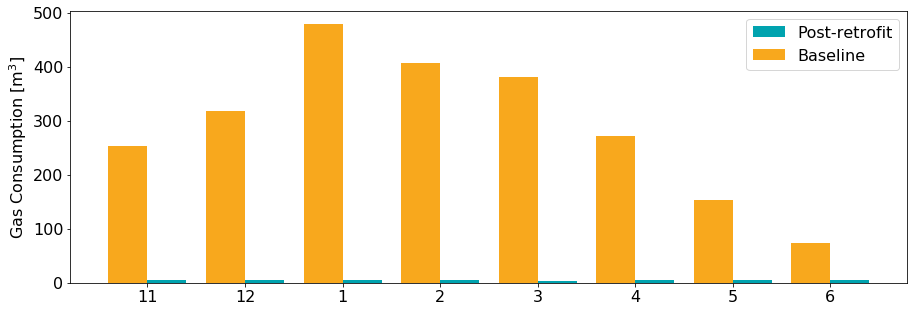

In [154]:
# Visualize
labels = [0,11,12,1,2,3,4,5,6] # Don't know why I need the 0...
pos = [0,1,2,3,4,5,6,7]
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(pos,post_gas_data.m3, width = 0.4, align = 'edge', color = step_blue, label = 'Post-retrofit')
ax.bar(pos,post_gas_data.modelled_m3, width = -0.4, align = 'edge', color = step_gold, label = 'Baseline')
ax.set_ylabel('Gas Consumption [m$^{3}$]')
ax.set_xticklabels(labels)
plt.legend()

Now calculate totals for actual and modelled baseline gas consumption.

In [155]:
# Actual post-retrofit gas consumption
post_gas_total = post_gas_data.m3.sum()
post_gas_total

40

In [156]:
# Modelled baseline gas consumption
post_gas_base_total = post_gas_data.modelled_m3.sum()
post_gas_base_total

2334.3956615411835

In [157]:
# Gas savings
gas_savings = post_gas_base_total - post_gas_total
gas_savings

2294.3956615411835

In [158]:
# Percentage gas savings
1-post_gas_total/post_gas_base_total

0.9828649441656383

Calculate totals for actual and modelled baseline electricity consumption.

In [159]:
# Add modelled baseline to post-retrofit elec data consumption dataframe
# Recall - baseline is what would have happened had there been no heat pump retrofit
post_elec_data['modelled_kWh'] = [base_elec_model(x) for x in post_elec_data.HDDs]
post_elec_data

,From,To,Off-Peak,Mid-Peak,On-Peak,kWh,HDDs,CDDs,modelled_kWh
22,2021-11-01,2021-11-30,713.25,176.45,191.15,1080.85,355.212500,0.000000,303.900737
23,2021-12-01,2021-12-31,964.37,253.53,246.47,1464.37,447.708333,0.000000,300.780154
24,2022-01-01,2022-01-31,1610.28,314.37,321.33,2245.98,732.379167,0.000000,291.176056
25,2022-02-01,2022-02-28,1235.67,258.33,278.88,1772.88,562.070833,0.000000,296.921843
26,2022-03-01,2022-03-31,963.42,217.97,242.93,1424.32,463.058333,0.000000,300.262282
27,2022-04-01,2022-04-30,838.31,153.10,180.11,1171.52,284.004167,0.000000,306.303132
28,2022-05-01,2022-05-31,426.49,83.14,88.50,598.13,74.758333,6.520833,313.362575
29,2022-06-01,2022-06-30,260.76,64.17,65.12,390.05,16.991667,14.150000,315.311481


[Text(0, 0, '0'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6')]

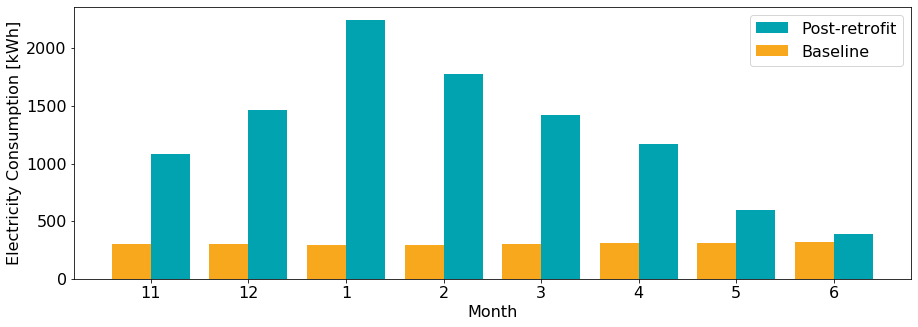

In [160]:
# Visualize
pos = [1,2,3,4,5,6,7,8]
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(pos,post_elec_data.kWh.to_list(), width = 0.4, align = 'edge', color = step_blue, label = 'Post-retrofit')
ax.bar(pos,post_elec_data.modelled_kWh.to_list(), width = -0.4, align = 'edge', color = step_gold, label = 'Baseline')
ax.set_ylabel('Electricity Consumption [kWh]')
ax.set_xlabel('Month') #It doesn't align perfectly by month but it's simpler to plot this way
plt.legend()
ax.set_xticklabels(labels)

In [161]:
#Actual post-retrofit electricity consumption
post_elec_total = post_elec_data.kWh.sum()
post_elec_total

10148.1

In [162]:
# Modelled baseline - what electricity consumption would have been if nothing changed
post_elec_baseline = post_elec_data.modelled_kWh.sum()
post_elec_baseline

2428.0182588632115

In [163]:
# Increase in electricity consumption
elec_increase = post_elec_total - post_elec_baseline
elec_increase

7720.081741136789

### 4.3 HDD Correction and Recalculate Savings

Note that the post-retrofit electricity consumption dataframe goes from 11-01-2021 to 06-30-2022. The post-retrofit gas dataframe goes from 10-23-2021 to 06-22-2022 - so both contain 8 months of data. However, they are offset by approximately 2 weeks. The gas dataframe includes more of October and less of June. Can look at the impact of that offset by looking at the total HDDs for the post-retrofit electricity dataframe and the post-retrofit gas dataframe.

In [164]:
# HDDs in gas dataframe
post_gas_data.HDDs.sum()

3013.9375

In [165]:
# HDDs in elec data frame
post_elec_data.HDDs.sum()

2936.1833333333334

In [166]:
# Difference in HDDs
HDD_diff = post_gas_data.HDDs.sum()-post_elec_data.HDDs.sum()
HDD_diff

77.7541666666666

The gas data has more HDDs and this would unfairly inflate the gas savings. The modelled baseline gas consumption needs to be corrected such that it that it is representative of a similar amount of HDDs as the electricity data. To do that, I can just take the slope of the baseline gas model multiply it be the HDD difference and use that as a correction term.

In [167]:
# Calculate correction term for baseline gas model
m3_HDD_corr = HDD_diff*base_model_gas.coef_[0]
m3_HDD_corr

47.13944839755425

Now need to recalculate the baseline gas consumption and the savings.

In [168]:
post_gas_base_total_corr = post_gas_base_total - m3_HDD_corr
post_gas_base_total_corr

2287.2562131436293

In [169]:
gas_savings_corr = post_gas_base_total_corr - post_gas_total
gas_savings_corr

2247.2562131436293

It was not a huge correction (only 2%) but better to be correct. Also need to correct for the HRV which would have increased the heating load post-retrofit. The homeowner noted a significant improvement in indoor air quality. A detailed calculation has been done for a previous study and estimated the HRV required a 7% correction to the baseline gas consumption (https://sustainabletechnologies.ca/app/uploads/2021/12/HP_Case_Study_3.pdf). That number has also been used here. 

In [170]:
post_gas_base_total_corr = (post_gas_base_total - m3_HDD_corr)*1.07
post_gas_base_total_corr

2447.3641480636834

In [171]:
gas_savings_corr = post_gas_base_total_corr - post_gas_total
gas_savings_corr

2407.3641480636834

In [172]:
# Percentage gas savings
100-post_gas_total/post_gas_base_total_corr*100

98.36558854424474

## 5 COP Estimate

Based on the electricity increase and gas savings it is possible to estimate a COP. To be clear, COP was not monitored. This is just a high-level check on the reasonableness of the data. The gas savings is related to heat energy that was formerly provided by the furnace but is now provided by the ASHP. Converting gas savings to kWh and then multiplying by the efficiency of the previous furnace provides the numerator of the COP equation - the heat that was delivered. We know the prior furnace was mid-efficiency and installed in 2008 but do not know the specific make and model, nor do we do know if the rated performance was achieved in practice. For this exercise, it was assumed that the previous furnace efficiency was 80% or 85%.

A second complication is that a small part of the gas savings (and new electrical consumptions) comes from electrifying the water heater. The gas savings from the water heater can be estimated by looking at the pre-retrofit data. For example in summer 2020, the gas consumption averaged 35 m3 per month. Post-retrofit the only remaining gas load was the stove and it averaged 5 m3 per month. Gas savings from the water heat might then be estimated at 30 m3 per month or 240 m3 for 8 months. It is approximately 10% of the total gas savings. For the purpose of this high level check on COP we can therefore just ignore the fact that the utility impacts are due both to the ASHP and heat pump water heater.

In [173]:
COP_85 = (gas_savings_corr * 10.6 * 0.85) / elec_increase # Assume previous furnace was 80% 
COP_85

2.809601206484099

In [174]:
COP_80 = (gas_savings_corr * 10.6 * 0.80) / elec_increase # Assume previous furnace was 80% 
COP_80

2.6443305472791523

The gas savings and electricity increase suggests the COP is 2.64 if the former furnace was 80% efficient or 2.81 if it was 85% efficient. Note that it is also likely the ASHP has lower electricity consumption for the blower and this will serve to inflate the COP calculation above, but it is nonetheless a real source of savings. The HSPF for the central system (2.5 ton) is 9.0 (Region IV), and is 12.5 for ductless system (0.75 ton). This translates to a seasonal average COP of 2.64 and 3.67. We can look at the data from the post-retrofit period and compare against the ASHRAE data from Zone IV and Zone V to see which value we ought to expect this installation to be closer to. 

In [175]:
# Calculate a weighted COP from the two ratings
Region_IV_weighted_COP = 2.64*2.5/(2.5+0.75) + 3.67*0.75/(2.5+0.75)
Region_IV_weighted_COP

2.8776923076923078

So we would hope to get a COP of 2.88 if the climate conditions near the post-retrofit period were near the assumptions of Region IV. Let's look.

In [176]:
# Get data from post-retrofit period
start_date = datetime.datetime.strptime("2021-10-23","%Y-%m-%d")
end_date = datetime.datetime.strptime("2022-06-22","%Y-%m-%d")
weather_post_retrofit = toronto_weather.loc[(toronto_weather.index > start_date) & (toronto_weather.index < end_date)]                                  

In [177]:
# Have a look
weather_post_retrofit.head()

,temperature,HDDs,CDDs
date_time_local,,,
2022-06-21 23:00:00,28.7,0.0,0.154167
2022-06-21 22:00:00,27.4,0.0,0.100000
2022-06-21 21:00:00,29.1,0.0,0.170833
2022-06-21 20:00:00,32.7,0.0,0.320833
2022-06-21 19:00:00,34.7,0.0,0.404167


In [178]:
# Get ASHRAE Region Data from AHRI 210/240 Standard
ASHRAE_Regions = pd.read_csv("AHRAE_Regions_Workbook.csv")
ASHRAE_Regions

,F,C,IV,V
0,62,16.666667,0.132,0.106
1,57,13.888889,0.110,0.092
2,52,11.111111,0.103,0.086
3,47,8.333333,0.093,0.076
4,42,5.555556,0.100,0.078
5,37,2.777778,0.109,0.087
6,32,0.000000,0.126,0.102
7,27,-2.777778,0.087,0.094
8,22,-5.555556,0.055,0.074
9,17,-8.333333,0.036,0.055


In [179]:
# Define bins for a histogram - the bin midpoints should be the same as the ASHRAE temp data
bins = (ASHRAE_Regions.C - (2.77/2)).to_list()
bins = [(2.77/2 + 16.67)] + bins
bins.reverse()
bins

[-31.94055556,
 -29.162777780000003,
 -26.385,
 -23.60722222,
 -20.829444440000003,
 -18.051666670000003,
 -15.27388889,
 -12.49611111,
 -9.718333332999999,
 -6.940555556,
 -4.162777778,
 -1.385,
 1.392777778,
 4.170555556,
 6.948333332999999,
 9.72611111,
 12.50388889,
 15.281666670000002,
 18.055000000000003]

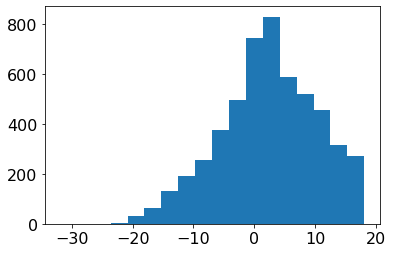

In [180]:
# Create a histogram
hist_results = plt.hist(weather_post_retrofit.temperature,bins)

In [181]:
# Number of hours below 18 C - this is need to put histogram results on same scale as ASHRAE data
number_hours = len(weather_post_retrofit.loc[weather_post_retrofit.temperature < 18.1])

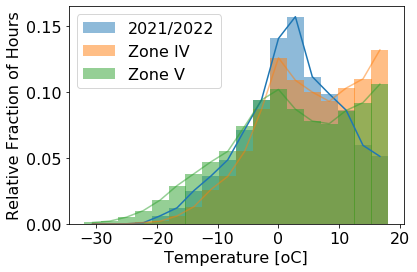

In [182]:
# Visualize

# Create x values for histogram
ASHRAE_temps = ASHRAE_Regions.C.to_list()
ASHRAE_temps.reverse()

# Plot all data
plt.bar(ASHRAE_temps,hist_results[0]/number_hours,alpha = 0.5,width=2.8, label = "2021/2022")
plt.bar(ASHRAE_Regions.C,ASHRAE_Regions.IV,alpha=0.5,width=2.8, label = "Zone IV")
plt.bar(ASHRAE_Regions.C,ASHRAE_Regions.V,alpha=0.5,width=2.8, label = "Zone V")
plt.plot(ASHRAE_temps,hist_results[0]/number_hours)
plt.plot(ASHRAE_Regions.C,ASHRAE_Regions.IV,alpha=0.5)
plt.plot(ASHRAE_Regions.C,ASHRAE_Regions.V,alpha=0.5)

plt.xlabel('Temperature [oC]')
plt.ylabel('Relative Fraction of Hours')

plt.legend()

It's clear that the post-retrofit period was colder than the assumptions of Region IV but not as cold as that for Region V. So we ought to expect that COP is something a bit less than the Region IV of 2.88 since the post-retrofit period was colder. We estimated it at actually 2.64 to 2.81 depending on if the furnace was 80% or 85% efficient - which we can't know. Overall, it lines up near expectations.

## 6 Utility Rates and Emission Factors

### 6.1 Gas Rates

The marginal cost of natural gas was estimated using the Ontario Energy Board (OEB) bill calculator, available at: https://www.oeb.ca/rates-and-your-bill/bill-calculator. Two sample bills were calculated in November 2022 for an Enbridge service area, one for 100 m3 consumption and one for 200 m3. These are shown below. 

![GasCalc2.png](GasCalc2.png)

The difference in cost between the two bills is 61.6 dollars - for a difference in consumption of 100 m$^{3}$. It follows that the marginal rate for gas was estimated at 0.616 dollars per m3. The price of natural gas has increased drastically in 2022 due to the war in the Ukraine and shortage of natural gas. It is not known how long prices will remain inflated. The approach taken in this case study series is simply to apply current utility rates. The case srudy document also considers a scenario where the rates are 20% lower.

At the end of 2020 the federal government announced a new carbon pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15 dollars per tonne annually to reach 170 dollars by 2030. This considered later in the analysis.

In [183]:
# Define gas rate
gas_rate = 0.616 # $/m3

### 6.2 Electricity Rate 
The current marginal electricity rates were also calculated using the OEB bill calculator. Two bills were calculated one for a 500 kWh and one for 600 kWh. The bills assumed a TOU breakdown of 60% off-peak, 20% mid-peakm and 20% on-peak. This breakdown considers that the daily TOU breakdown includes 12 hours off-peak (50%), 6 hours mid-peak (25%) and 6 hours on-peak (25%) (but all off-peak on weekends), and also that it is typically colder during the night. This weights electricity consumption further towards the off-peak TOU. 

The difference between the two bills was used to calculated the marginal electricity rate for the TOU. This kind of approach was necessary to properly capture all marginal costs, and is helpful because it is straightforward and electricity pricing structures can be complex with mutiple line items. Bills were calculated in January 2021.

The results are shown below. For an increase in 100 kWh of electricity consumption, it cost an additional 11.7 dollars.  Marginal electricity cost was estimated at 0.117 dollars per kWh.
![Elec_Calc2.png](Elec_Calc2.png)

In [184]:
# Define gas rate
elec_rate = 0.117 # $/kWh

The emission factors for electricity and natural gas are include both marginal and annual emission factors from the TAF report "A Clearer View on Ontario's Emissions" 2021 Edition. Fugitive emissions have been ignored.

In [185]:
# Define emission factor assumptions
AEF_elec_2021 = 0.031 # From TAF 2021 report "A Clearer View on Ontario's Emissions"
MEF_elec_2021 = 0.113
AEF_elec_2036 = 0.094 # From TAF 2021 report "A Clearer View on Ontario's Emissions"
MEF_elec_2036 = 0.340
EF_gas = 1.89 # in units kg CO2e per m3 from Canada's NIR report

## 7 Current Utility Cost and Carbon Reductions

In [186]:
# Increased electricity cost
elec_cost_increase = elec_increase*elec_rate
elec_cost_increase

903.2495637130044

In [187]:
# Decrease in natural gas costs
gas_cost_reduction = gas_savings_corr*gas_rate
gas_cost_reduction

1482.936315207229

In [188]:
# Net utility cost savings
net_cost_reduction = gas_cost_reduction - elec_cost_increase
net_cost_reduction

579.6867514942246

Visualize change in bills at current rates.

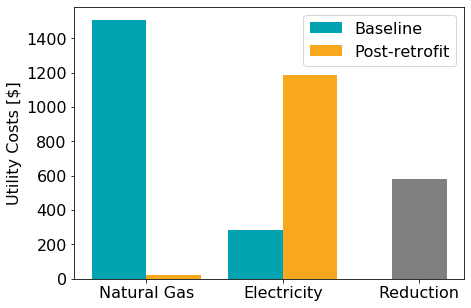

In [189]:
# Create lists for plot
baseline = [post_gas_base_total_corr*gas_rate,post_elec_baseline*elec_rate]
postretrofit = [post_gas_total*gas_rate,post_elec_total*elec_rate]
reduction = [net_cost_reduction]

# Plot 
fig, ax = plt.subplots(figsize = (7,5))
ax.bar([1,2], baseline, width = -0.4, align = 'edge', color = step_blue, label = 'Baseline')
ax.bar([1,2], postretrofit, width = 0.4, align = 'edge', color = step_gold, label = 'Post-retrofit')
ax.bar([3],reduction, color = 'grey', width = 0.4)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Natural Gas','Electricity', 'Reduction'])
ax.set_ylabel('Utility Costs [$]')
ax.legend()
#ax.set_ylim(0,1000)

In [190]:
# Carbon savings 2021 annual emission factor
carbon_reduction_AEF_2021 = (gas_savings_corr * EF_gas) - (elec_increase*AEF_elec_2021)
carbon_reduction_AEF_2021

4310.595705865121

In [191]:
# Percentage reduction 2021 AEF
100*(1-((elec_increase*AEF_elec_2021)/(gas_savings_corr * EF_gas)))

94.740069571368

In [192]:
# Carbon savings 2036 annual emission factor
carbon_reduction_AEF_2036 = (gas_savings_corr * EF_gas) - (elec_increase*AEF_elec_2036)
carbon_reduction_AEF_2036

3824.230556173504

In [193]:
# Percentage reduction 2036 AEF
100*(1-((elec_increase*AEF_elec_2036)/(gas_savings_corr * EF_gas)))

84.05053353898685

In [194]:
# Carbon reduction 2021 marginal emission factor
carbon_reduction_MEF_2021 = (gas_savings_corr * EF_gas) - (elec_increase*MEF_elec_2021)
carbon_reduction_MEF_2021

3677.5490030919045

In [195]:
# Percentage reduction 2021 MEF
100*(1-((elec_increase*MEF_elec_2021)/(gas_savings_corr * EF_gas)))

80.8267052117608

In [196]:
# Carbon reduction 2036 marginal emission factor
carbon_reduction_MEF_2036 = (gas_savings_corr * EF_gas) - (elec_increase*MEF_elec_2036)
carbon_reduction_MEF_2036

1925.0904478538532

In [197]:
# Percentage reduction 2036 MEF
100*(1-((elec_increase*MEF_elec_2036)/(gas_savings_corr * EF_gas)))

42.31044046016521

## 8 Future Cost Reductions Due to Carbon Pricing

At the end of 2020 the federal government announced a new carbon pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15$\$$ per year to reach $\$$170 by 2030. This is outlined in the dataframe below. Note the schedule is not available beyond 2030 and has been assumed to stay at $\$$170 beyond 2030 but this may be conservative. Also note the calculated rate ignores other fluctuations in the cost of natural gas and simply adds additional charges onto the current rate.

In [198]:
# Import carbon charge data
# You can see this aligns with carbon charge data from enbridge
# https://www.enbridgegas.com/residential/my-account/rates/federal-carbon-charge (below)
nat_gas_rate_df = pd.read_csv("nat_gas_carbon_pricing.csv")
nat_gas_rate_df.head(16)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3)
0,2022,50,0.097875
1,2023,65,0.127238
2,2024,80,0.156600
3,2025,95,0.185963
4,2026,110,0.215325
5,2027,125,0.244688
6,2028,140,0.274050
7,2029,155,0.303412
8,2030,170,0.332775
9,2031,170,0.332775


![Enbridge_CC2.png](Enbridge_CC2.png)

In [199]:
# Add cost escalation due to carbon charge
gas_rate_no_carbon_charge = gas_rate - 0.0979
nat_gas_rate_df['Gas_Rate'] = [(gas_rate_no_carbon_charge + x) if (y < 170) else (gas_rate_no_carbon_charge + 0.332775)*(1.02)**(z-2030) for x,y,z in zip(nat_gas_rate_df['Carbon Charge Natural Gas ($/m3)'],nat_gas_rate_df['Carbon Tax ($/tonne)'],nat_gas_rate_df['Year'])]

#Scenario with lower gas rates by 25%
nat_gas_rate_df['Gas_Rate_Low'] = [(gas_rate_no_carbon_charge*0.80 + x) if (y < 170) else (gas_rate_no_carbon_charge*0.75 + 0.332775)*(1.02)**(z-2030) for x,y,z in zip(nat_gas_rate_df['Carbon Charge Natural Gas ($/m3)'],nat_gas_rate_df['Carbon Tax ($/tonne)'],nat_gas_rate_df['Year'])]
nat_gas_rate_df.head(15)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Gas_Rate_Low
0,2022,50,0.097875,0.615975,0.512355
1,2023,65,0.127238,0.645338,0.541718
2,2024,80,0.156600,0.674700,0.571080
3,2025,95,0.185963,0.704063,0.600442
4,2026,110,0.215325,0.733425,0.629805
5,2027,125,0.244688,0.762787,0.659168
6,2028,140,0.274050,0.792150,0.688530
7,2029,155,0.303412,0.821512,0.717893
8,2030,170,0.332775,0.850875,0.721350
9,2031,170,0.332775,0.867893,0.735777


In [200]:
# Add electricity cost escalation - 
# Assume 2% per year there has been no recent long-term energy plan to for a better estimate
# Just add it to natural gas data frame
nat_gas_rate_df['Elec_Rate'] = [elec_rate*(1.02)**x for x in nat_gas_rate_df.index]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Gas_Rate_Low,Elec_Rate
0,2022,50,0.097875,0.615975,0.512355,0.117000
1,2023,65,0.127238,0.645338,0.541718,0.119340
2,2024,80,0.156600,0.674700,0.571080,0.121727
3,2025,95,0.185963,0.704063,0.600442,0.124161
4,2026,110,0.215325,0.733425,0.629805,0.126645
5,2027,125,0.244688,0.762787,0.659168,0.129177
6,2028,140,0.274050,0.792150,0.688530,0.131761
7,2029,155,0.303412,0.821512,0.717893,0.134396
8,2030,170,0.332775,0.850875,0.721350,0.137084
9,2031,170,0.332775,0.867893,0.735777,0.139826


The rates are determined. But now need adjust the data to also include savings from operations in September and October which up until now have been ignored.

In [201]:
# Want to do two things here:
# 1) Estimate savings for a full season including September and October
# 2) Correct savings to be against a 95% efficient furnace rather than an (estimated) 80% efficient one
# Assumed 80% here to be more conservative. It could have been 85%. "Mid-efficiency" means greater than 78% AFUE.
# For September & October need to model the baseline (already have a model) AND the post-retrofit (no model yet)

# September HDDs
sept_HDDs = HDD_total(datetime.datetime.strptime('09/01/2021','%m/%d/%Y'),datetime.datetime.strptime('09/30/2021','%m/%d/%Y'))
sept_HDDs

{'HDDs': 28.15416666666667, 'CDDs': 0.620833333333333}

In [202]:
# October HDDs
oct_HDDs = HDD_total(datetime.datetime.strptime('10/01/2021','%m/%d/%Y'),datetime.datetime.strptime('10/31/2021','%m/%d/%Y'))
oct_HDDs

{'HDDs': 103.32083333333333, 'CDDs': 0.025000000000000057}

In [203]:
# Determine baseline electricity for Sept
sept_baseline_kWh = base_elec_model(sept_HDDs['HDDs'])
sept_baseline_kWh

314.9348853576393

In [204]:
# Determine baseline electricity for Oct
oct_baseline_kWh = base_elec_model(oct_HDDs['HDDs'])
oct_baseline_kWh

312.3989458270286

In [205]:
# Determine baseline gas consumption for Sept
sept_baseline_m3 = baseline_gas(sept_HDDs['HDDs'])
sept_baseline_m3

80.46355474967393

In [206]:
# Determine baseline gas consumption for Oct
oct_baseline_m3 = baseline_gas(oct_HDDs['HDDs'])
oct_baseline_m3

126.034298498234

In [207]:
# Total baseline electricity for Sept/Oct
sept_oct_baseline_kWh = sept_baseline_kWh + oct_baseline_kWh
sept_oct_baseline_kWh

627.3338311846679

In [208]:
# Total baseline gas for Sept/Oct
sept_oct_baseline_m3 = sept_baseline_m3 + oct_baseline_m3
sept_oct_baseline_m3

206.49785324790793

In [209]:
# Post-retrofit gas consumption 
# This is what would have been the case had the retrofit happened prior to Septemeber
sept_postretro_m3 = 5
oct_postretro_m3 = 5
sept_oct_postretro_m3 = sept_postretro_m3 + oct_postretro_m3
sept_oct_postretro_m3

10

In [210]:
# Will need to model the post-retrofit electricity consumption and use that model 
# to estimate electricity consumption for Sept/Oct 2021 with the heat pump 
# Look at data
post_elec_data

,From,To,Off-Peak,Mid-Peak,On-Peak,kWh,HDDs,CDDs,modelled_kWh
22,2021-11-01,2021-11-30,713.25,176.45,191.15,1080.85,355.212500,0.000000,303.900737
23,2021-12-01,2021-12-31,964.37,253.53,246.47,1464.37,447.708333,0.000000,300.780154
24,2022-01-01,2022-01-31,1610.28,314.37,321.33,2245.98,732.379167,0.000000,291.176056
25,2022-02-01,2022-02-28,1235.67,258.33,278.88,1772.88,562.070833,0.000000,296.921843
26,2022-03-01,2022-03-31,963.42,217.97,242.93,1424.32,463.058333,0.000000,300.262282
27,2022-04-01,2022-04-30,838.31,153.10,180.11,1171.52,284.004167,0.000000,306.303132
28,2022-05-01,2022-05-31,426.49,83.14,88.50,598.13,74.758333,6.520833,313.362575
29,2022-06-01,2022-06-30,260.76,64.17,65.12,390.05,16.991667,14.150000,315.311481


coefficient of determination: 0.9793871689770851
intercept: 356.0943427382887
slope: [2.48599778]


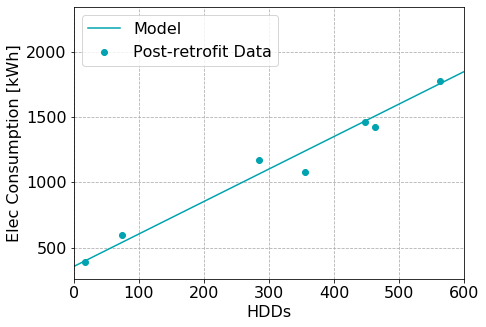

In [211]:
# Calculate regression line for post_retrofit elec data
x = np.array(post_elec_data.HDDs).reshape((-1, 1))
y = np.array(post_elec_data.kWh)
post_model_elec = LinearRegression()
post_model_elec.fit(x, y)
post_model_elec_r_sq_2 = post_model_elec.score(x, y)
print('coefficient of determination:', post_model_elec_r_sq_2)
print('intercept:', post_model_elec.intercept_)
print('slope:', post_model_elec.coef_)

# Function for baseline model
def post_elec_model(HDDs):
    kWh = post_model_elec.coef_[0]*HDDs + post_model_elec.intercept_
    return kWh

# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,600]
y = [post_elec_model(a) for a in x]
plt.figure(figsize = (7,5))
plt.scatter(post_elec_data.HDDs,post_elec_data.kWh, color = step_blue, label = 'Post-retrofit Data')
plt.plot(x,y, color = step_blue, label = 'Model')
plt.xlim(0,600)
plt.xlabel('HDDs')
plt.ylabel('Elec Consumption [kWh]')
plt.grid(ls='--')
plt.legend(loc = 2)

Model looks good.

In [212]:
# Use model to determine September electricity consumption if ASHP system was used
sept_postretro_kWh = post_elec_model(sept_HDDs['HDDs'])
sept_postretro_kWh 

426.0855386629004

In [213]:
# Use model to determine October electricity consumption if ASHP system was used
oct_postretro_kWh = post_elec_model(oct_HDDs['HDDs'])
oct_postretro_kWh 

612.9497053759379

In [214]:
# Total for Sept and Oct
sept_oct_postretro_kWh = sept_postretro_kWh + oct_postretro_kWh
sept_oct_postretro_kWh

1039.0352440388383

In [215]:
# Total Gas decrease for Sept and Oct if ASHP is used
sept_oct_gas_decrease = sept_oct_baseline_m3 - sept_oct_postretro_m3
sept_oct_gas_decrease

196.49785324790793

In [216]:
# Total Elec increase for Sept and Oct if ASHP is used
sept_oct_elec_increase = sept_oct_postretro_kWh - sept_oct_baseline_kWh
sept_oct_elec_increase

411.70141285417037

In [217]:
# COP for Sept and Oct
sept_oct_COP = (sept_oct_gas_decrease * 10.6 * 0.80) / sept_oct_elec_increase 
sept_oct_COP

4.047355057614251

In [218]:
# Now want to add Sept/Oct gas savings to total
# Also want to correct here to use a high-efficiency furnace (95%) as a point of reference rather than mid.
# This decreases the savings
gas_savings_corr2 = (gas_savings_corr + sept_oct_gas_decrease) * (0.80/0.95) # Want to lower the gas savings to reflect what they would be vs. 95% furnace
gas_savings_corr2

2192.7258958413404

In [219]:
# Add Sept/Oct elec increase to the total
elec_increase_corr = sept_oct_elec_increase + elec_increase
elec_increase_corr

8131.783153990959

In [220]:
# Can now calculate full annual savings with those corrections made
nat_gas_rate_df['Annual_Gas_Savings_m3'] = [gas_savings_corr2 for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Elec_Increase_kWh'] = [elec_increase_corr for x in nat_gas_rate_df.Elec_Rate] #elec_increase + add_elec_increase
nat_gas_rate_df['Annual_Gas_Savings_dol'] = [gas_savings_corr2*x for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Gas_Savings_dol_Low'] = [gas_savings_corr2*x for x in nat_gas_rate_df.Gas_Rate_Low] #Scenario with lower rates
nat_gas_rate_df['Annual_Elec_Increase_dol'] = [elec_increase_corr*x for x in nat_gas_rate_df.Elec_Rate]
nat_gas_rate_df['Annual_Net_Cost_Change'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings_dol,nat_gas_rate_df.Annual_Elec_Increase_dol)]
nat_gas_rate_df['Annual_Net_Cost_Change_Low'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings_dol_Low,nat_gas_rate_df.Annual_Elec_Increase_dol)]
nat_gas_rate_df.head(15)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Gas_Rate_Low,Elec_Rate,Annual_Gas_Savings_m3,Annual_Elec_Increase_kWh,Annual_Gas_Savings_dol,Annual_Gas_Savings_dol_Low,Annual_Elec_Increase_dol,Annual_Net_Cost_Change,Annual_Net_Cost_Change_Low
0,2022,50,0.097875,0.615975,0.512355,0.117000,2192.725896,8131.783154,1350.664334,1123.454076,951.418629,-399.245705,-172.035447
1,2023,65,0.127238,0.645338,0.541718,0.119340,2192.725896,8131.783154,1415.048248,1187.837990,970.447002,-444.601246,-217.390989
2,2024,80,0.156600,0.674700,0.571080,0.121727,2192.725896,8131.783154,1479.432162,1252.221905,989.855942,-489.576220,-262.365963
3,2025,95,0.185963,0.704063,0.600442,0.124161,2192.725896,8131.783154,1543.816076,1316.605819,1009.653060,-534.163016,-306.952758
4,2026,110,0.215325,0.733425,0.629805,0.126645,2192.725896,8131.783154,1608.199990,1380.989733,1029.846122,-578.353868,-351.143611
5,2027,125,0.244688,0.762787,0.659168,0.129177,2192.725896,8131.783154,1672.583904,1445.373647,1050.443044,-622.140860,-394.930603
6,2028,140,0.274050,0.792150,0.688530,0.131761,2192.725896,8131.783154,1736.967818,1509.757561,1071.451905,-665.515913,-438.305656
7,2029,155,0.303412,0.821512,0.717893,0.134396,2192.725896,8131.783154,1801.351733,1574.141475,1092.880943,-708.470789,-481.260532
8,2030,170,0.332775,0.850875,0.721350,0.137084,2192.725896,8131.783154,1865.735647,1581.722825,1114.738562,-750.997085,-466.984263
9,2031,170,0.332775,0.867893,0.735777,0.139826,2192.725896,8131.783154,1903.050360,1613.357281,1137.033333,-766.017026,-476.323948


In [221]:
# Total net cost to 2036 not including gas customer charge
nat_gas_rate_df.Annual_Net_Cost_Change.sum()

-10025.19276512488

In [222]:
# Total net cost to 2036 not including gas customer charge - assuming low gas rate scenario
nat_gas_rate_df.Annual_Net_Cost_Change_Low.sum()

-6096.078906043144

In [223]:
# Total net cost savings to 2036 including gas custmer charge
nat_gas_rate_df['Annual_Net_Cost_Change_GCC'] =  nat_gas_rate_df.Annual_Net_Cost_Change - 300
nat_gas_rate_df.Annual_Net_Cost_Change_GCC.sum()

-14525.192765124882

In [224]:
# Total net cost savings to 2036 including gas custmer charge
nat_gas_rate_df['Annual_Net_Cost_Change_GCC_Low'] =  nat_gas_rate_df.Annual_Net_Cost_Change_Low - 300
nat_gas_rate_df.Annual_Net_Cost_Change_GCC_Low.sum()

-10596.078906043143

In [225]:
# Discount all future savings to today's dollars assuming 2% discount rate
nat_gas_rate_df['PV_2'] = [x/(1.02)**(y+1) for x,y in zip(nat_gas_rate_df.Annual_Net_Cost_Change_GCC,nat_gas_rate_df.index)]
PV_2 = nat_gas_rate_df['PV_2'].sum()
PV_2

-12287.482114673792

In [226]:
# Discount all future savings to today's dollars assuming 2% discount rate - low gas rate scenario
nat_gas_rate_df['PV_2_Low'] = [x/(1.02)**(y+1) for x,y in zip(nat_gas_rate_df.Annual_Net_Cost_Change_GCC_Low,nat_gas_rate_df.index)]
PV_2_Low = nat_gas_rate_df['PV_2_Low'].sum()
PV_2_Low

-8959.513022845547

In [227]:
# Discount all future savings to today's dollars assuming 5% discount rate
nat_gas_rate_df['PV_5'] = [x/(1.05)**(y+1) for x,y in zip(nat_gas_rate_df.Annual_Net_Cost_Change_GCC,nat_gas_rate_df.index)]
PV_5 = nat_gas_rate_df['PV_5'].sum()
PV_5

-9741.345770308888

In [228]:
# Discount all future savings to today's dollars assuming 5% discount rate
nat_gas_rate_df['PV_5_Low'] = [x/(1.05)**(y+1) for x,y in zip(nat_gas_rate_df.Annual_Net_Cost_Change_GCC_Low,nat_gas_rate_df.index)]
PV_5_Low = nat_gas_rate_df['PV_5_Low'].sum()
PV_5_Low

-7096.0596102452955

In [229]:
# Discount all future savings to today's dollars assuming 7% discount rate
nat_gas_rate_df['PV_7'] = [x/(1.07)**(y+1) for x,y in zip(nat_gas_rate_df.Annual_Net_Cost_Change_GCC,nat_gas_rate_df.index)]
PV_7 = nat_gas_rate_df['PV_7'].sum()
PV_7

-8443.07890300505

In [230]:
# Discount all future savings to today's dollars assuming 7% discount rate
nat_gas_rate_df['PV_7_Low'] = [x/(1.07)**(y+1) for x,y in zip(nat_gas_rate_df.Annual_Net_Cost_Change_GCC_Low,nat_gas_rate_df.index)]
PV_7_Low = nat_gas_rate_df['PV_7_Low'].sum()
PV_7_Low

-6145.276027941139

In [231]:
nat_gas_rate_df.head(20)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Gas_Rate_Low,Elec_Rate,Annual_Gas_Savings_m3,Annual_Elec_Increase_kWh,Annual_Gas_Savings_dol,Annual_Gas_Savings_dol_Low,Annual_Elec_Increase_dol,Annual_Net_Cost_Change,Annual_Net_Cost_Change_Low,Annual_Net_Cost_Change_GCC,Annual_Net_Cost_Change_GCC_Low,PV_2,PV_2_Low,PV_5,PV_5_Low,PV_7,PV_7_Low
0,2022,50,0.097875,0.615975,0.512355,0.117000,2192.725896,8131.783154,1350.664334,1123.454076,951.418629,-399.245705,-172.035447,-699.245705,-472.035447,-685.535005,-462.779850,-665.948290,-449.557569,-653.500659,-441.154624
1,2023,65,0.127238,0.645338,0.541718,0.119340,2192.725896,8131.783154,1415.048248,1187.837990,970.447002,-444.601246,-217.390989,-744.601246,-517.390989,-715.687472,-497.300066,-675.375280,-469.288879,-650.363566,-451.909327
2,2024,80,0.156600,0.674700,0.571080,0.121727,2192.725896,8131.783154,1479.432162,1252.221905,989.855942,-489.576220,-262.365963,-789.576220,-562.365963,-744.035307,-529.930007,-682.065626,-485.792863,-644.529392,-459.058142
3,2025,95,0.185963,0.704063,0.600442,0.124161,2192.725896,8131.783154,1543.816076,1316.605819,1009.653060,-534.163016,-306.952758,-834.163016,-606.952758,-770.637687,-560.730530,-686.267977,-499.341536,-636.378971,-463.041353
4,2026,110,0.215325,0.733425,0.629805,0.126645,2192.725896,8131.783154,1608.199990,1380.989733,1029.846122,-578.353868,-351.143611,-878.353868,-651.143611,-795.552161,-589.760830,-688.213239,-510.188057,-626.254169,-464.256396
5,2027,125,0.244688,0.762787,0.659168,0.129177,2192.725896,8131.783154,1672.583904,1445.373647,1050.443044,-622.140860,-394.930603,-922.140860,-694.930603,-818.834694,-617.078488,-688.115708,-518.567915,-614.461391,-463.061603
6,2028,140,0.274050,0.792150,0.688530,0.131761,2192.725896,8131.783154,1736.967818,1509.757561,1071.451905,-665.515913,-438.305656,-965.515913,-738.305656,-840.539706,-642.739504,-686.174134,-524.700046,-601.274786,-459.779657
7,2029,155,0.303412,0.821512,0.717893,0.134396,2192.725896,8131.783154,1801.351733,1574.141475,1092.880943,-708.470789,-481.260532,-1008.470789,-781.260532,-860.720108,-666.798342,-682.572726,-528.787880,-586.939181,-454.700743
8,2030,170,0.332775,0.850875,0.721350,0.137084,2192.725896,8131.783154,1865.735647,1581.722825,1114.738562,-750.997085,-466.984263,-1050.997085,-766.984263,-879.427345,-641.778121,-677.482092,-494.404895,-571.672778,-417.188621
9,2031,170,0.332775,0.867893,0.735777,0.139826,2192.725896,8131.783154,1903.050360,1613.357281,1137.033333,-766.017026,-476.323948,-1066.017026,-776.323948,-874.505255,-636.856031,-654.441981,-476.595561,-541.909001,-394.643730


In [232]:
# Incremental cost assuming 2% discount rate and 0% financing and 10-year term (like in Greener Homes Loan)
cost_ASHPs = 41827 -1000 #1000 rebate for water heater
cost_conv = 20000
cost_inc = cost_ASHPs - cost_conv
payment = (cost_ASHPs/10)
year = [1,2,3,4,5,6,7,8,9,10]

sum_2 = 0
for yr in year:
    sum_2 = sum_2 + payment/(1.02)**yr
Inc_2 = sum_2-cost_conv
Inc_2

16673.199804985168

In [233]:
#Incremental cost
cost_inc

20827

In [234]:
#Annual payment
payment

4082.7

In [235]:
# Upfront cost in today's dollars assuming 2% discount rate and 0% financing
sum_2

36673.19980498517

In [236]:
# Percentage reduction due to 0% financing
(1-sum_2/cost_ASHPs)*100

10.17414993757766

In [237]:
# Incremental cost assuming 5% discount rate and 0% financing
sum_5 = 0
for yr in year:
    sum_5 = sum_5 + payment/(1.05)**yr
sum_5-cost_conv
Inc_5 = sum_5-cost_conv
Inc_5

11525.52719538282

In [238]:
# Upfront cost in today's dollars assuming 5% discount rate and 0% financing
sum_5

31525.52719538282

In [239]:
# Percentage reduction due to 0% financing assuming 5% discount rate
(1-sum_5/cost_ASHPs)*100

22.78265070815191

In [240]:
# Incremental cost assuming 7% discount rate and 0% financing
sum_7 = 0
for yr in year:
    sum_7 = sum_7 + payment/(1.07)**yr
Inc_7 = sum_7-cost_conv
Inc_7

8675.176357165528

In [241]:
# Upfront cost in today's dollars assuming 7% discount rate and 0% financing
sum_7

28675.17635716553

In [242]:
# Percentage reduction due to 0% financing
(1-sum_7/cost_ASHPs)*100

29.76418459067399

In [243]:
# Scenario 1: NPV no 0%-financing 
S1_max = -cost_inc - PV_2 # Use the full incremental cost (not discounted) but savings are discounted
S1_max # Maximum NPV from Scenario 1

-8539.517885326208

In [244]:
# NPV no 0%-financing 2% discount - Low gas scenario
S1_max_Low = -cost_inc - PV_2_Low
S1_max_Low

-11867.486977154453

In [245]:
# NPV no 0%-financing 5% discount
-cost_inc - PV_5

-11085.654229691112

In [246]:
# NPV no 0%-financing 5% discount - Low gas scenario
-cost_inc - PV_5_Low

-13730.940389754705

In [247]:
# NPV no 0%-financing 7% discount
S1_min = -cost_inc - PV_7 # "Min" because it is a lower value
S1_min

-12383.92109699495

In [248]:
# NPV no 0%-financing 7% discount - Low gas scenario
S1_min_Low = -cost_inc - PV_7_Low
S1_min_Low

-14681.723972058862

In [249]:
# Scenario 2: 0% Financing; No Rebate - this one isn't in white paper
# NPV 0%-financing 2% discount
S2_min = -Inc_2 - PV_2
S2_min

-4385.717690311376

In [250]:
# NPV 0%-financing 2% discount - Low gas scenario
S2_min_Low = -Inc_2 - PV_2_Low
S2_min_Low

-7713.686782139621

In [251]:
# NPV 0%-financing 5% discount
-Inc_5 - PV_5

-1784.1814250739317

In [252]:
# NPV 0%-financing 5% discount - Low gas scenario
-Inc_5 - PV_5_Low

-4429.467585137524

In [253]:
# NPV 0%-financing 7% discount
S2_max = -Inc_7 - PV_7
S2_max

-232.09745416047917

In [254]:
# NPV 0%-financing 7% discount - Low gas scenario
S2_max_Low = -Inc_7 - PV_7_Low
S2_max_Low

-2529.9003292243897

In [255]:
# Scenario 3: 0% Financing and Rebate
# NPV 0%-financing 2% discount and rebate (additional $4,000 since $1,000 was already included)
S3_min = -Inc_2 - PV_2 + 4000
S3_min

-385.7176903113759

In [256]:
# NPV 0%-financing 2% discount and rebate (additional $4,000 since $1,000 was already included) - Low gas rate scenario
S3_min_Low = -Inc_2 - PV_2_Low + 4000
S3_min_Low

-3713.686782139621

In [257]:
# NPV 0%-financing 5% discount and rebate (additional $4,000 since $1,000 was already included)
-Inc_5 - PV_5 + 4000

2215.8185749260683

In [258]:
# NPV 0%-financing 5% discount and rebate (additional $4,000 since $1,000 was already included) - Low gas rate scenario
-Inc_5 - PV_5_Low + 4000

-429.4675851375241

In [259]:
# NPV 0%-financing 7% discount and rebate (additional $4,000 since $1,000 was already included)
S3_max = -Inc_7 - PV_7 + 4000
S3_max

3767.902545839521

In [260]:
# NPV 0%-financing 7% discount and rebate (additional $4,000 since $1,000 was already included) - Low gas rate scenario
S3_max_Low = -Inc_7 - PV_7_Low + 4000
S3_max_Low

1470.0996707756103

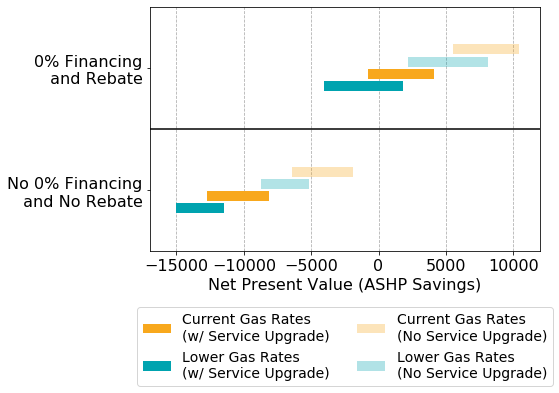

In [261]:
# Make the NPV summary plot
a=0.05
b= a + a/2
w=10
service_up_cost = 6300

# Current Rates
y1 = [1-a,1-a]
x1 = [S1_min,S1_max]

y3 = [2-a,2-a]
x3 = [S3_min,S3_max]

# Current Rates; No Service Upgrade
y1_no = [1+(2*b),1+(2*b)]
x1_no = [S1_min+service_up_cost,S1_max+service_up_cost]

y3_no = [2+(2*b),2+(2*b)]
x3_no = [S3_min+service_up_cost,S3_max+service_up_cost]

# 20% Lower Gas Rates; Incl Service Upgrade"
y1L = [1-(2*b),1-(2*b)]
x1L = [S1_min_Low,S1_max_Low]

y3L = [2-(2*b),2-(2*b)]
x3L = [S3_min_Low,S3_max_Low]
       
# 20% Lower Gas Rates; Incl Service Upgrade"
y1L_no = [1+(a),1+(a)]
x1L_no = [S1_min_Low+service_up_cost,S1_max_Low+service_up_cost]

y3L_no = [2+(a),2+(a)]
x3L_no = [S3_min_Low+service_up_cost,S3_max_Low+service_up_cost]

fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)

ax.plot(x1, y1, lw = w, color = step_gold)
ax.plot(x3, y3, lw = w, color = step_gold)

ax.plot(x1L, y1L, lw = w, color = step_blue)
ax.plot(x3L, y3L, lw = w, color = step_blue)

ax.plot(x1_no, y1_no, lw = w, color = step_gold, alpha = 0.3)
ax.plot(x3_no, y3_no, lw = w, color = step_gold, alpha = 0.3)

ax.plot(x1L_no, y1L_no, lw = w, color = step_blue, alpha = 0.3)
ax.plot(x3L_no, y3L_no, lw = w, color = step_blue, alpha = 0.3)

ax.set_yticks(ticks = [1,2])
ax.set_yticklabels(labels = ['No 0% Financing\n and No Rebate','0% Financing\n and Rebate'])
ax.set_ylim(0.5,2.5)
ax.set_xlim(-17000,12000)
ax.set_xlabel('Net Present Value (ASHP Savings)')
ax.axhline(y = 1.5, color = 'black')

legend_elements = [Patch(facecolor= step_gold, label='Current Gas Rates\n(w/ Service Upgrade)'),
                  Patch(facecolor= step_blue, label='Lower Gas Rates\n(w/ Service Upgrade)'),
                  Patch(facecolor= step_gold, alpha = 0.3, label='Current Gas Rates\n(No Service Upgrade)'),
                  Patch(facecolor= step_blue, alpha = 0.3, label='Lower Gas Rates\n(No Service Upgrade)')]


# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.9, box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(handles=legend_elements,loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=2, fontsize = 14)
ax.grid(axis = 'x', ls = '--')


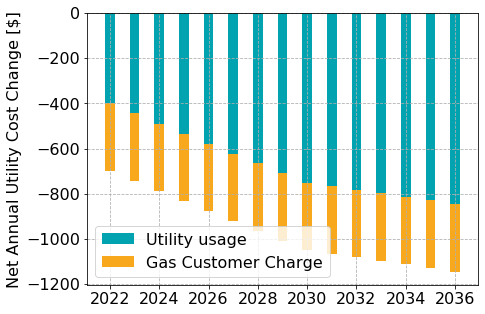

In [262]:
# Visualize lifetime to 2036
gcc = [-300]*15

plt.figure(figsize=(7,5))
plt.bar(nat_gas_rate_df.Year,nat_gas_rate_df.Annual_Net_Cost_Change,color=step_blue, align = 'center', width = 0.4, label = 'Utility usage')
plt.bar(nat_gas_rate_df.Year,gcc,bottom=nat_gas_rate_df.Annual_Net_Cost_Change, align = 'center', width = 0.4, color = step_gold, label = 'Gas Customer Charge')
plt.grid(ls='--')
plt.ylabel('Net Annual Utility Cost Change [$]')
plt.legend()

This analysis is taking the energy savings from the post-retrofit period and assuming that it will be constant on an annual basis moving forward. This is a simplification. In reality, future savings will vary with the annual changes in weather. It is useful to confirm whether or not the post-retrofit was an outlying year that is not a good representation of future savings. To do that it's possible just to look at total HDDs of the post-retrofit period vs. the same time period from 10 previous years. 

In [263]:
HDD_total(datetime.datetime.strptime("2021-09-01","%Y-%m-%d"),datetime.datetime.strptime("2022-06-01","%Y-%m-%d"))['HDDs']

3050.6666666666665

In [264]:
year = ["2020-21","2019-20","2018-19","2017-18","2016-17","2015-16","2014-15","2013-14","2012-13"]
strts = ["2020-09-01","2019-09-01","2018-09-01","2017-09-01","2016-09-01","2015-09-01","2014-09-01","2013-09-01","2012-09-01"]
ends = ["2021-06-01","2020-06-01","2019-06-01","2018-06-01","2017-06-01","2016-06-01","2015-06-01","2014-06-01","2013-06-01"]
HDD_list = []

for st,en, yr in zip(strts,ends, year):
    HDDs_ = HDD_total(datetime.datetime.strptime(st,"%Y-%m-%d"),datetime.datetime.strptime(en,"%Y-%m-%d"))['HDDs']
    HDD_list.append(HDDs_)
    print(str(yr) + " " + str(HDDs_))

2020-21 2957.75
2019-20 3091.4125
2018-19 3403.9375
2017-18 3242.558333333333
2016-17 2842.520833333333
2015-16 2821.704166666667
2014-15 3517.9666666666667
2013-14 3672.3916666666664
2012-13 3085.9249999999997


In [265]:
# Mean HDDs
sum(HDD_list)/len(HDD_list)

3181.796296296296

In [266]:
3051/3181

0.959132348318139

The total HDDs for the post-retrofit period in this analysis are 4% lower than the mean HDDs for the same period across the last 10 years. It follows that 2021-2022 is not an outlier.
